# Classifying spam mail

The goal of this project is training a classifier that is able to distinguish regular mail (ham) from spam mail. The content of the notebook is as follows:

1. Importing libraries;
2. Loading and first exploration of data;
3. Exploring data and feature generation;
4. Cleaning data;
5. Splitting, scaling numerical features, and vectorizing data;
6. Trying classifiers.

#### 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# NLP pre-processing
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy import sparse
import spacy
import string
import re
import contractions

# Algorithms
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report

#### 2. Loading and first exploration of data

In [2]:
df_orginal = pd.read_csv('spam_ham_dataset.csv', header = 0, encoding='ISO-8859-1', index_col = 0, usecols = [0,1,2])

In [3]:
df = df_orginal.copy()
df.head()

,label,text
605,ham,Subject: enron methanol ; meter # : 988291\r\n...
2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
4685,spam,"Subject: photoshop , windows , office . cheap ..."
2030,ham,Subject: re : indian springs\r\nthis deal is t...


In [4]:
df.shape

(5171, 2)

In [5]:
df.duplicated().sum()

178

In [6]:
# We drop duplicates to prevent overfitting

df = df.drop_duplicates()

#### 3. Exploring data and feature generation

I notice that the text column contains several interesting words that might be useful as individual features, such as 'subject', 're:','fowarded by', and 'unsubscribe/subscribe'.

In [7]:
# We make sure every mail has a 'Subject:' part
df['text'].str.contains('Subject:').sum() / df.shape[0]

# We add columns for: subject, respons (re:), forwarded, subscribe
start_chars, end_chars = 'Subject: ', '\r'
df['subject'] = df['text'].apply(lambda x: x[x.find(start_chars) + len(start_chars) : x.find(end_chars)])
df['text'] = df['text'].apply(lambda x: x[x.find(end_chars):])
df['response'] = np.where(df.subject.str.contains('re :'), 1,0)
df['forwarded'] = np.where(df.text.str.contains('forwarded'),1,0)
df['subscribe'] = np.where(df.text.str.contains('subscribe'),1,0)

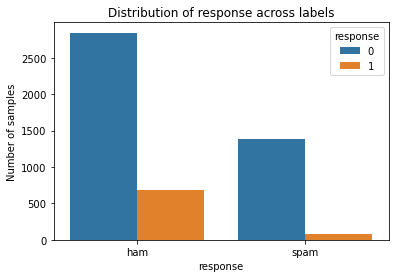

Ham percentage true:  0.19
Spam percentage true:  0.06


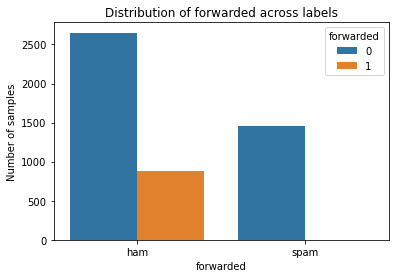

Ham percentage true:  0.25
Spam percentage true:  0.0


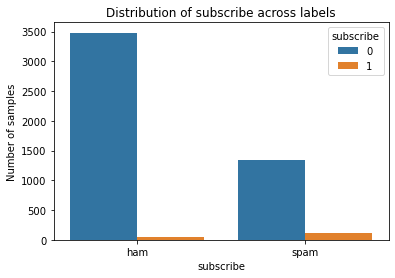

Ham percentage true:  0.01
Spam percentage true:  0.08


In [8]:
features = ['response','forwarded','subscribe']

for feature in features:
    sns.countplot(data = df, x = 'label', hue = feature)
    _, h1, _, s1 = df.groupby('label')[feature].value_counts(normalize = True)
    plt.xlabel(feature)
    plt.ylabel('Number of samples')
    plt.title('Distribution of {} across labels'.format(feature))
    plt.show()
    print('Ham percentage true: ',round(h1,2))
    print('Spam percentage true: ',round(s1,2))

We see some interesting things, especially regarding 'forwarded' and 'response', where there are clear differences between ham and spam. For subscribe the difference is small, suprisingly.

In [9]:
# We add two more features: word count and character count

df['n_chars'] = df.text.str.len()
df['n_words'] = df.text.apply(lambda x: len([words for words in x.split()]))

In [10]:
print('Mean')
df.groupby('label').agg({'n_chars':'mean','n_words':'mean'}).T.round()

Mean


label,ham,spam
n_chars,955.0,1200.0
n_words,222.0,229.0


In [11]:
print('Standard Deviation')
df.groupby('label').agg({'n_chars':'std','n_words':'std'}).T.round()

Standard Deviation


label,ham,spam
n_chars,1401.0,1838.0
n_words,337.0,348.0


We do see some differences between ham and spam regarding word count and character count. However, the high standard deviations suggest that the differences are not significant.

#### 4. Cleaning data

In [12]:
# We change the label to 0 or 1, as algorithms work with numbers.

df.label = np.where(df.label == 'spam',1,0)

The mails contain a lot of symbols which we will be removing.

In [13]:
# We replace " ' " and fix contractions, we remove punctuations and lowercase the text

df['cl_text'] = df.text.str.replace(" ' ", "'")
df['cl_text'] = df.cl_text.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
df['cl_text'] = df.cl_text.apply(lambda x: re.sub('\W+',' ', x))
df['cl_text'] = df.cl_text.str.lower()

# We apply the same transformations to subject

df['cl_subject'] = df.subject.str.replace(" ' ", "'")
df['cl_subject'] = df.cl_subject.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))
df['cl_subject'] = df.cl_subject.apply(lambda x: re.sub('\W+',' ', x))
df['cl_subject'] = df.cl_subject.str.lower()

In [14]:
# Next, we lemmatize the words in the documents

lemma = WordNetLemmatizer()
df['cl_text'] = df.cl_text.apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x.split()]))
df['cl_subject'] = df.cl_subject.apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x.split()]))

In [15]:
# We check for missing values

df.isna().sum()

label         0
text          0
subject       0
response      0
forwarded     0
subscribe     0
n_chars       0
n_words       0
cl_text       0
cl_subject    0
dtype: int64

The dataset seems quite straightforward; no missing values and a decent amount of spam labelled mails. Nonetheless, I will keep in mind the unbalanced distribution of the target variable.

#### 5. Splitting, scaling numerical features, and vectorizing data

In [16]:
df = df.drop(['text','subject'], axis = 1)

In [17]:
# I split train and test, as usual, to have data the model has never seen

X = df.drop('label', axis = 1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3744, 7)
(3744,)
(1249, 7)
(1249,)


In [18]:
# I scale the numerical data as certain models perform better, fitting on train to prevent leaking any info

scaler = StandardScaler()

num_features = ['n_words','n_chars']

for feature in num_features:
    scaler = StandardScaler()
    X_train[[feature]] = scaler.fit_transform(X_train[[feature]])
    X_test[[feature]] = scaler.transform(X_test[[feature]])

In [19]:
# Using tfidf to vectorize the textual features, again fitting on train.

vector_columns = ['cl_text','cl_subject']

train_sparse = X_train.drop(vector_columns, axis =1).values
test_sparse = X_test.drop(vector_columns, axis = 1).values

for column in vector_columns:
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(X_train[column])
    test_tfidf = tfidf.transform(X_test[column])
    
    train_sparse = sparse.hstack((train_sparse, train_tfidf))
    test_sparse = sparse.hstack((test_sparse, test_tfidf))

In [20]:
print(train_sparse.shape)
print(test_sparse.shape)

(3744, 41676)
(1249, 41676)


#### 6. Try some initial classifiers

We try some classifiers without specifying any hyper_parameters.

In [21]:
models = [('xgboost',XGBClassifier(use_label_encoder = False)),
        ('tree', DecisionTreeClassifier()),
        ('lr', LogisticRegression()),
        ('svc', SVC()),
         ('rf',RandomForestClassifier())]

results = []

for model in models:
    clf = model[1].fit(train_sparse,y_train)
    preds = clf.predict(test_sparse)
    
    f1 = f1_score(y_test, preds)
    f1_macro = f1_score(y_test, preds, average = 'macro')
    acc = accuracy_score(y_test, preds)
    
    results.append([model[0],acc,f1, f1_macro,preds])

[14:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
results_df = pd.DataFrame(results, columns = ('model','acc','f1','f1 macro','preds')).sort_values('acc', ascending = False)
results_df.drop('preds', axis = 1)

,model,acc,f1,f1 macro
2,lr,0.985588,0.976501,0.983054
3,svc,0.982386,0.971503,0.979378
4,rf,0.971978,0.952251,0.966210
0,xgboost,0.963971,0.940239,0.957226
1,tree,0.948759,0.914667,0.939027


I check the predictions distribution to quickly check if the models aren't just predicting the most dominant class.

In [23]:
for i in results_df.preds:
    print(pd.Series(i).value_counts())

0    860
1    389
dtype: int64
0    854
1    395
dtype: int64
0    893
1    356
dtype: int64
0    873
1    376
dtype: int64
0    876
1    373
dtype: int64


In [24]:
preds = RandomForestClassifier().fit(train_sparse,y_train).predict(test_sparse)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       872
           1       0.98      0.94      0.96       377

    accuracy                           0.97      1249
   macro avg       0.97      0.96      0.97      1249
weighted avg       0.97      0.97      0.97      1249



We see the RandomForestClassifier does really well, being able to both predict spam and ham properly. The only other classifiers that come close are XGBoost and the DecisionTreeClassifier.